In [25]:
#bu veri setinde ilgi alanım olduğu için Japonya'daki kiraz ağaçlarının yıllara göre tam açma tarihlerini ele alan bir veri seti kullandım.
#Bu veri setiyle iklim değişikliğinin kiraz çiçeklerine olan etkisini de gözlemlemiş olurum diye düşündüm. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

df = pd.read_csv("sakura_full_bloom_dates.csv")

# Veriyi daha iyi okuyabilmek ve görebilmek için  Long formata çevirdim.
df_long = df.melt(id_vars=["Site Name", "Currently Being Observed"],
                       var_name="Year", value_name="Date")

In [26]:
# Long formata çevirdikten sonra artık gerek kalmadığı için yıl ve tarih sütunlarını temizledim
df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
df_long["Date"] = pd.to_datetime(df_long["Date"], errors="coerce")

In [27]:
# Eksik verileri çıkardım
df_long = df_long.dropna(subset=["Year", "Date"])

In [28]:
# Kiraz çiçeklerinin yılın kaçıncı günü açtığı net görünecek şekilde hesapladım
df_long["Day_of_Year"] = df_long["Date"].dt.dayofyear

# En sonunda ilk 5 satır şu şekilde oldu:
df_long.head()

,Site Name,Currently Being Observed,Year,Date,Day_of_Year
0,Wakkanai,True,1953.0,1953-05-30,150
1,Rumoi,False,1953.0,1953-05-13,133
2,Asahikawa,True,1953.0,1953-05-16,136
3,Abashiri,True,1953.0,1953-05-26,146
4,Sapporo,True,1953.0,1953-05-14,134


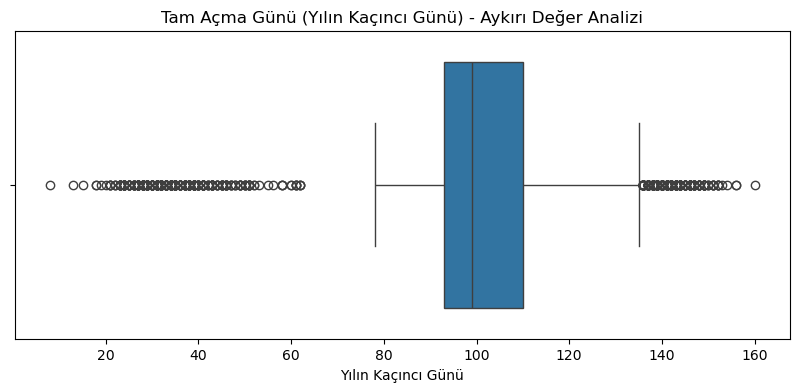

In [29]:
#Aykırı Değer Analizi için:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_long, x="Day_of_Year")
plt.title("Tam Açma Günü (Yılın Kaçıncı Günü) - Aykırı Değer Analizi")
plt.xlabel("Yılın Kaçıncı Günü")
plt.show()

In [30]:
# Kiraz çiçekleri genellikle Mart sonu–Nisan ortası (yani yılın 85–110. günleri civarında) tam açıyor.

# Ancak birkaç aşırı erken açma durumu var (örneğin Ocak sonu – Şubat başı gibi). Bunları incelemek için:

In [31]:
# Z score ile aykırı değer hesaplama: 

# Ortalama ve standart sapma
mean_day = df_long["Day_of_Year"].mean()
std_day = df_long["Day_of_Year"].std()

# Z-score hesabı
df_long["Z_score"] = (df_long["Day_of_Year"] - mean_day) / std_day

# Aykırı değerleri filtreleme
outliers = df_long[np.abs(df_long["Z_score"]) > 3]

# Aykırıları göster
print(outliers[["Site Name", "Year", "Date", "Day_of_Year", "Z_score"]])

            Site Name    Year       Date  Day_of_Year   Z_score
93               Naze  1953.0 1953-02-02           33 -3.110402
399              Naze  1956.0 1956-01-24           24 -3.522966
501              Naze  1957.0 1957-01-31           31 -3.202083
504        Miyakojima  1957.0 1957-01-25           25 -3.477126
605   Ishigaki Island  1958.0 1958-01-27           27 -3.385445
...               ...     ...        ...          ...       ...
7131             Naze  2022.0 2022-01-31           31 -3.202083
7136             Naha  2022.0 2022-02-01           32 -3.156242
7233             Naze  2023.0 2023-02-01           32 -3.156242
7236       Miyakojima  2023.0 2023-02-03           34 -3.064561
7238             Naha  2023.0 2023-01-30           30 -3.247923

[197 rows x 5 columns]


In [32]:
# Bunlar Japonya’nın güneyinde yer alan sıcak iklime sahip subtropikal bölgeler, bu yüzden açma zamanları çok daha erken olduğu gözlemlendi.
# İklim değişikliği ile alakalı gerçek veri olduğu için aynen bırakıldı.

In [33]:
#Bu analizde hedefim tam açma gününü tahmin etmek olduğu için bu bir regresyon problemi.
#Bunun için RMSE, MAE, RMSLE kullanılabilir. Ben MAE kullanacağım.


In [34]:
actual = df_long["Day_of_Year"]
mean_prediction = actual.mean()
predicted = [mean_prediction] * len(actual)

mae = mean_absolute_error(actual, predicted)

print(f"Ortalama Tahmin (Gün): {mean_prediction:.2f}")
print(f"MAE (Ortalama Mutlak Hata): {mae:.2f} gün")

Ortalama Tahmin (Gün): 100.85
MAE (Ortalama Mutlak Hata): 14.19 gün


In [35]:
#Train-Test Bölme
#Bu projede hedefim tam açma gününü tahmin etmek olduğu için yani geleceği tahmin etme olduğu için eski yılları train, yenileri test için kullanacağım

In [39]:
# Year sütununu int'e çevirdim ki bölebileyim
df_long["Year"] = df_long["Year"].astype(int)

# Train / Validation / Test böl
train = df_long[df_long["Year"] <= 2010]
val = df_long[(df_long["Year"] > 2010) & (df_long["Year"] <= 2016)]
test = df_long[df_long["Year"] > 2016]

# Kontrol için
print("Train:", len(train), "Validation:", len(val), "Test:", len(test))

Train: 5300 Validation: 350 Test: 399


In [40]:
#Model Deneme için 3 model tercih ettim. 
# Model 1 – Sabit Ortalama Tahmini (Baseline)
#Her şehir ve yıl için ortalama açma günü tahmini

#Model 2 – Şehir Bazlı Ortalama Tahmini
#Her şehrin geçmiş verilerindeki ortalama açma günü alınır ve o şehre özel tahmin.

#Model 3 – Yıla Göre Lineer Regresyon
#Yıllar arttıkça sakura günleri değişiyor mu? Bunu yıl değişkeni ile tahmin eden bir Linear Regression modeli.



In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [43]:
# MODEL 1: Genel Ortalama
mean_day = train["Day_of_Year"].mean()
val["Model1_Pred"] = mean_day
mae1 = mean_absolute_error(val["Day_of_Year"], val["Model1_Pred"])
print("Model 1 - Sabit Ortalama MAE:", round(mae1, 2))

Model 1 - Sabit Ortalama MAE: 16.33


In [44]:
# MODEL 2: Şehir Bazlı Ortalama
city_means = train.groupby("Site Name")["Day_of_Year"].mean()
val["Model2_Pred"] = val["Site Name"].map(city_means)
mae2 = mean_absolute_error(val["Day_of_Year"], val["Model2_Pred"])
print("Model 2 - Şehir Ortalaması MAE:", round(mae2, 2))

Model 2 - Şehir Ortalaması MAE: 5.27


In [45]:
# MODEL 3: Yıla Göre Linear Regression
X_train = train[["Year"]]
y_train = train["Day_of_Year"]
X_val = val[["Year"]]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
val["Model3_Pred"] = lr_model.predict(X_val)

mae3 = mean_absolute_error(val["Day_of_Year"], val["Model3_Pred"])
print("Model 3 - Linear Regression MAE:", round(mae3, 2))

Model 3 - Linear Regression MAE: 14.54


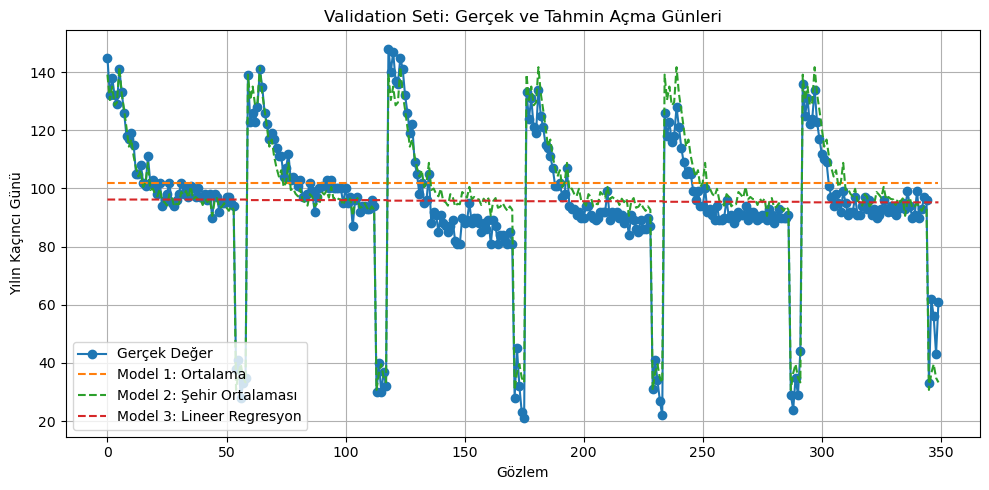

In [46]:
plt.figure(figsize=(10, 5))

plt.plot(val["Day_of_Year"].values, label="Gerçek Değer", marker='o')
plt.plot(val["Model1_Pred"].values, label="Model 1: Ortalama", linestyle='--')
plt.plot(val["Model2_Pred"].values, label="Model 2: Şehir Ortalaması", linestyle='--')
plt.plot(val["Model3_Pred"].values, label="Model 3: Lineer Regresyon", linestyle='--')

plt.title("Validation Seti: Gerçek ve Tahmin Açma Günleri")
plt.xlabel("Gözlem")
plt.ylabel("Yılın Kaçıncı Günü")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
#Sonuç olarak MODEL 2: Şehir Bazlı Ortalama'nın en düşük hata oranına sahip olduğu görülmüştür.